In [229]:
#importing all the basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import datetime

In [230]:
#importing the data
csv_file = 'taxi.csv'
df = pd.read_csv(csv_file, sep=',', index_col=0)

In [231]:
#getting rid of strange observations
df.drop(index=df[df['RatecodeID']==99].index, inplace=True) #one single row without payment
df.drop(index=df[df['passenger_count']==0].index, inplace=True)#one single row with just wrong values - distance is not zero, , the fair was negotiated, the money was paid, but no passengers. If there were more rows like that, we would assume it is a pre-ordered taxi, but there is the only one. So we delete it.
df.drop(index=df[df['trip_distance']>100].index, inplace=True)
df.drop(index=df[df['pickup_longitude']==0].index, inplace=True) #geographical coordinates are not really numerical, so replacing with mode, median or mean is not reasonable and keeping zeros is wrong. So we just sacrifice these rows
df.drop(index=df[df['dropoff_longitude']==0].index, inplace=True)
df.drop(index=df[df['dropoff_latitude']==0].index, inplace=True)
df.drop(index=df[df['pickup_latitude']==0].index, inplace=True)
df=df.reset_index().drop(columns='index', axis=1)    
df['fare_amount']=df['fare_amount'].abs()
df['extra']=df['extra'].abs()
df.loc[df[df.trip_distance<=0.001].index, 'mta_tax'] = 0
df['mta_tax']=df['mta_tax'].abs()
df['improvement_surcharge']=df['improvement_surcharge'].abs()
df.loc[df[df.trip_distance<=0.001].index,'improvement_surcharge']=0.0
df.loc[df[df.trip_distance>0.001].index,'improvement_surcharge']=0.3
df['total_amount']=df['total_amount'].abs()

In [232]:
def to_bool(string):
    if string=='N':
        flag=False
    if string=='Y':  
        flag=True
    return flag

df['store_and_fwd_flag']=df['store_and_fwd_flag'].apply(to_bool)

In [233]:
#dealing with the datetime
df.insert(column='pickuptime', value = pd.to_datetime(df['tpep_pickup_datetime'], format = '%Y-%m-%d %H:%M:%S'), loc=2)
df.insert(column='pickupweekday', value = df['pickuptime'].dt.dayofweek,  loc=3)
df.insert(column='pickupmonth', value = df['pickuptime'].dt.month, loc=4)
df.insert(column='pickuphour', value = df['pickuptime'].dt.hour, loc=5)
df.insert(column='pickupminute', value = df['pickuptime'].dt.minute, loc=6)
df.insert(column='pickupsecond', value = df['pickuptime'].dt.second, loc=7)
df.insert(column='dropofftime', value = pd.to_datetime(df['tpep_dropoff_datetime'], format = '%Y-%m-%d %H:%M:%S'),  loc=9)
df.insert(column='dropoffweekday', value = df['dropofftime'].dt.dayofweek,  loc=10)
df.insert(column='dropoffmonth', value = df['dropofftime'].dt.month, loc=11)
df.insert(column='dropoffhour', value = df['dropofftime'].dt.hour, loc=12)
df.insert(column='dropoffminute', value = df['dropofftime'].dt.minute, loc=13)
df.insert(column='dropoffsecond', value = df['dropofftime'].dt.second, loc=14)

In [234]:
import torch
import torch.nn as nn

This time we will focus on columns that are known at the time of the order. Those known a posteriori only are omitted

In [235]:
#we deal with the categorical columns first
cat_cols = ['payment_type', 'pickupmonth',
'pickupweekday', 'pickuphour', 
'passenger_count',
'RatecodeID']
catlist = []
for cat in cat_cols:
    df[cat] = df[cat].astype('category')
    catlist.append(df[cat].cat.codes.values)

cat_predictors = np.stack(catlist, axis=1)

In [236]:
#then come numeric (continuous) colums
cont_predictors = df.trip_distance.values.reshape(-1, 1)

In [237]:
#converting arrays to tensors
cats = torch.tensor(cat_predictors, dtype=torch.int64)
conts = torch.tensor(cont_predictors, dtype=torch.float)
y = torch.tensor(df.total_amount.values, dtype = torch.float).reshape(-1,1)

In [238]:
#making embeddings for categorical variables
cat_szs = [len(df[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) if size>1 else (12, 6) for size in cat_szs]

In [239]:
#creating a tabular model class
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
               
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x       

In [240]:
#creating a TabularModel class instance
torch.manual_seed(51)
model = TabularModel(emb_szs, conts.shape[1], 1, [50,50], p=0.4)

In [241]:
#setting criterion and optimizer
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [242]:
#train-test split 
batch_size = int(len(cats)/4)
test_size = int(batch_size *0.2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [243]:
#training the model
model.train()
epochs = 200
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)
    
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.2f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.2f}')

epoch:   1  loss:      20.36
epoch:  26  loss:      18.31
epoch:  51  loss:      12.04
epoch:  76  loss:       6.71
epoch: 101  loss:       5.09
epoch: 126  loss:       5.00
epoch: 151  loss:       4.67
epoch: 176  loss:       4.48
epoch: 200  loss:       4.47


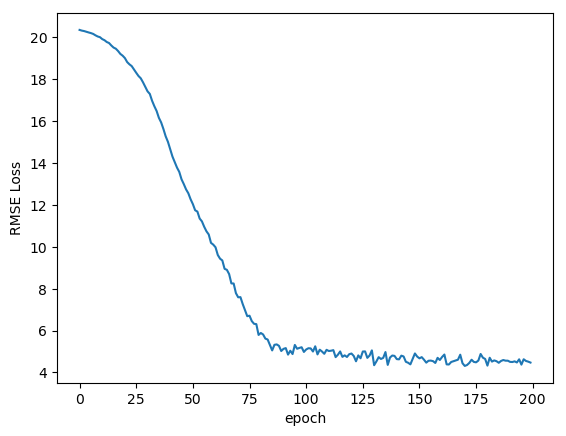

In [189]:
#plotting the progress
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')
plt.show()

In [190]:
#let us experiment with numbers of neurons
neuron_layers = [[10, 10], [30, 30], [60, 60], [100,100]]
loss_df = pd.DataFrame({'Epoch':list(range(epochs))})

for neurons in neuron_layers:
    torch.manual_seed(51)
    model = TabularModel(emb_szs, conts.shape[1], 1, neurons, p=0.4)
    criterion = nn.MSELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    losses = []
    for i in range(epochs):
        i+=1
        y_pred = model(cat_train, con_train)
        loss = torch.sqrt(criterion(y_pred, y_train))
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_df[f'Losses {neurons}'] = losses

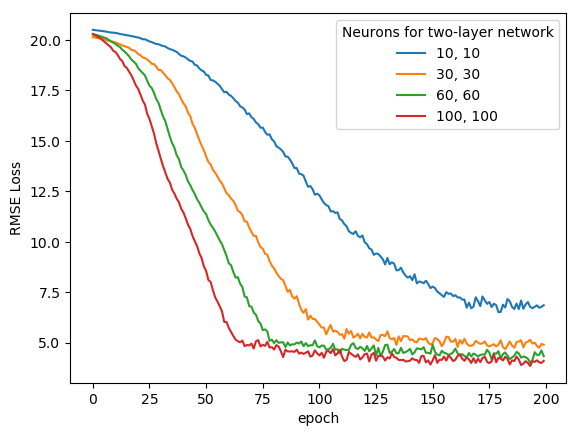

In [191]:
fig, ax = plt.subplots()
for neurons in neuron_layers:
    ax.plot(loss_df.Epoch, loss_df[f'Losses {neurons}'], label=f'{neurons[0]}, {neurons[1]}')

ax.legend(title = 'Neurons for two-layer network')
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')
plt.show()

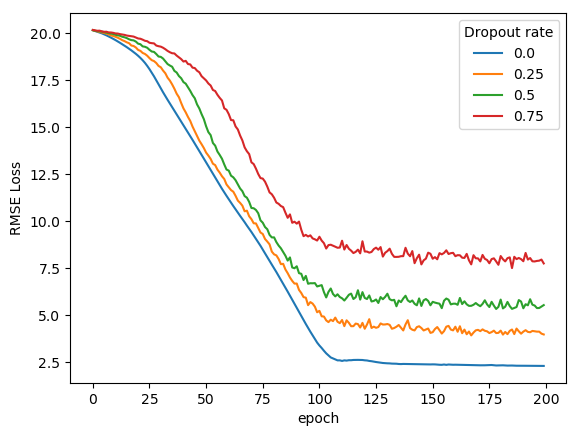

In [192]:
#what about dropout rate?
dropouts = np.arange(0, 1, .25)
loss_df = pd.DataFrame({'Epoch':list(range(epochs))})
fig, ax = plt.subplots()

for p in dropouts:
    torch.manual_seed(51)
    model = TabularModel(emb_szs, conts.shape[1], 1, [30, 30], p=p)
    criterion = nn.MSELoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

    losses = []
    for i in range(epochs):
        i+=1
        y_pred = model(cat_train, con_train)
        loss = torch.sqrt(criterion(y_pred, y_train))
        losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_df[f'Losses p={p}'] = losses
    
    ax.plot(loss_df.Epoch, loss_df[f'Losses p={p}'], label=f'{p}')

ax.legend(title = 'Dropout rate')
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')
plt.show()

So let us get back to the best model - 60x60 neurons (pursuant to the above graph it does not perform much worse than 100x100 model) and with 0.25 dropout rate (0 rate performs better, but is more likely to overfit)

In [193]:
torch.manual_seed(51)
model = TabularModel(emb_szs, conts.shape[1], 1, [60, 60], p=0.25)
criterion = nn.MSELoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [194]:
#testing 
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(criterion(y_val, y_test))
print(f'RMSE: {loss:.3f}')
#does not differ from the training that much

RMSE: 3.997


In [ ]:
#### a function to predict on user's input
def predict(model=model):
    payment_type = input('Enter payment type code (1 to 4)')
    pickupmonth = input('Enter pickup month (1 to 12)')
    pickupweekday = input('Enter pickup weekday (0 to 6)')
    pickuphour = input('Enter pickup hour (0 to 23)')
    passenger_count = input('Enter passenger count (1 to 4)')
    RatecodeID = input('Enter RatecodeID (1 to 6)')
    trip_distance = float(input('Enter trip distance in miles'))
    catlist = list(map(int, [payment_type, pickupmonth, pickupweekday, pickuphour, passenger_count, RatecodeID]))
    cats = torch.zeros((1, len(catlist)), dtype = torch.long)
    cats[0] = torch.tensor(catlist, dtype=torch.int64)
    conts = torch.zeros((1, 1), dtype = torch.float)
    conts[0] = torch.tensor(trip_distance, dtype=torch.float)
    model.eval()
    try:
        with torch.no_grad():
            y_val = round(model(cats, conts).item(), 2)
        print('The estimated total fee equals to', f'{y_val}', 'dollars')
    except RuntimeError:
        print('Wrong input. Try entering correct values')

predict()